In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Remove penguins with no sex for now

In [4]:
df = pd.read_csv('./penguin_cleaned.csv')

# Remove rows where 'sex' is NaN
#df_with_nan.drop(columns=['Unnamed: 0'], inplace=True)
#df = df_with_nan.dropna(subset=['sex'])
print(df.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen            36.7           19.3              193.0   
4  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3       3450.0  Female  
4       3650.0    Male  


Scale features, create basic kmeans model

In [33]:
# Get a dataframe of features
features_unscaled = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
labels = df['species']

# Initialise the StandardScaler and scale features
scaler = StandardScaler()
features = scaler.fit_transform(features_unscaled)

# Split the scaled data
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Fit KMeans on the training set
kmm = KMeans(n_clusters=3, random_state=42)
kmm.fit(features_train)

KMeans(n_clusters=3, random_state=42)

Plot clusters of example model

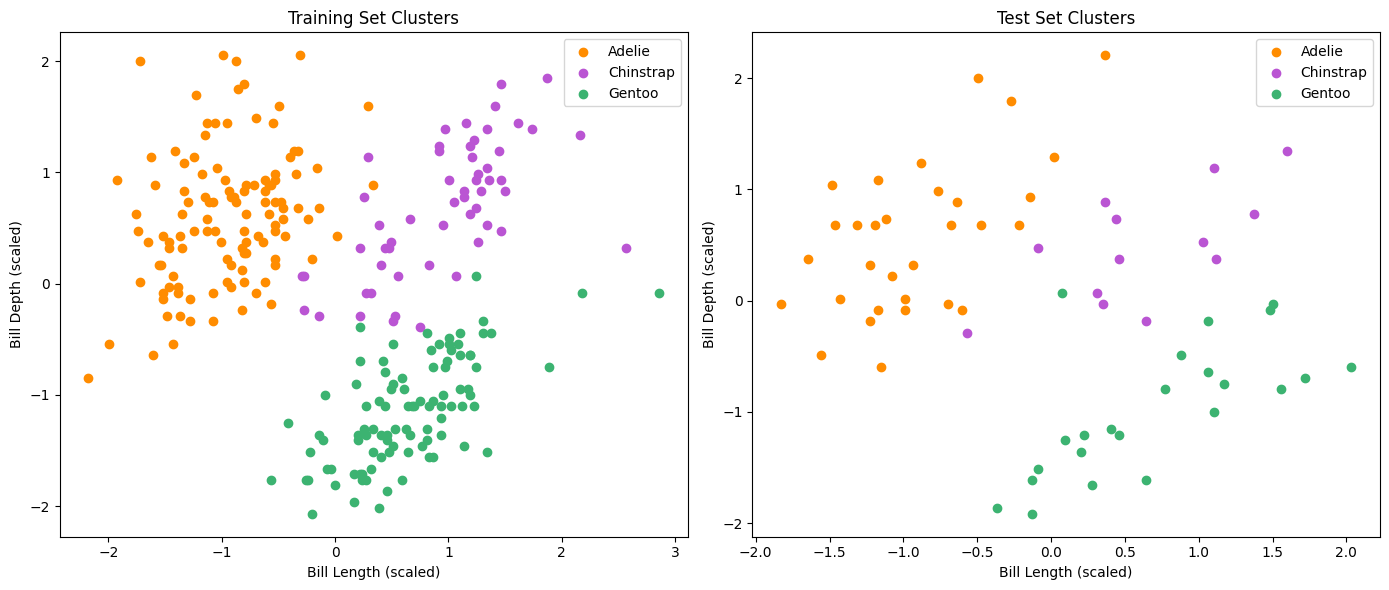

In [34]:
custom_palette = {
    'Adelie': 'darkorange',
    'Chinstrap': 'mediumorchid',
    'Gentoo': 'mediumseagreen'
}

# Plotting both training and test set clusters side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set
for species, color in custom_palette.items():
    points = features_train[labels_train == species]
    axs[0].scatter(points[:, 0], points[:, 1], c=color, label=f'{species}')
axs[0].set_xlabel('Bill Length (scaled)')
axs[0].set_ylabel('Bill Depth (scaled)')
axs[0].set_title('Training Set Clusters')
axs[0].legend()

# Test set
for species, color in custom_palette.items():
    points = features_test[labels_test == species]
    axs[1].scatter(points[:, 0], points[:, 1], c=color, label=f'{species}')
axs[1].set_xlabel('Bill Length (scaled)')
axs[1].set_ylabel('Bill Depth (scaled)')
axs[1].set_title('Test Set Clusters')
axs[1].legend()

plt.tight_layout()
plt.show()

Cluster plots for all features

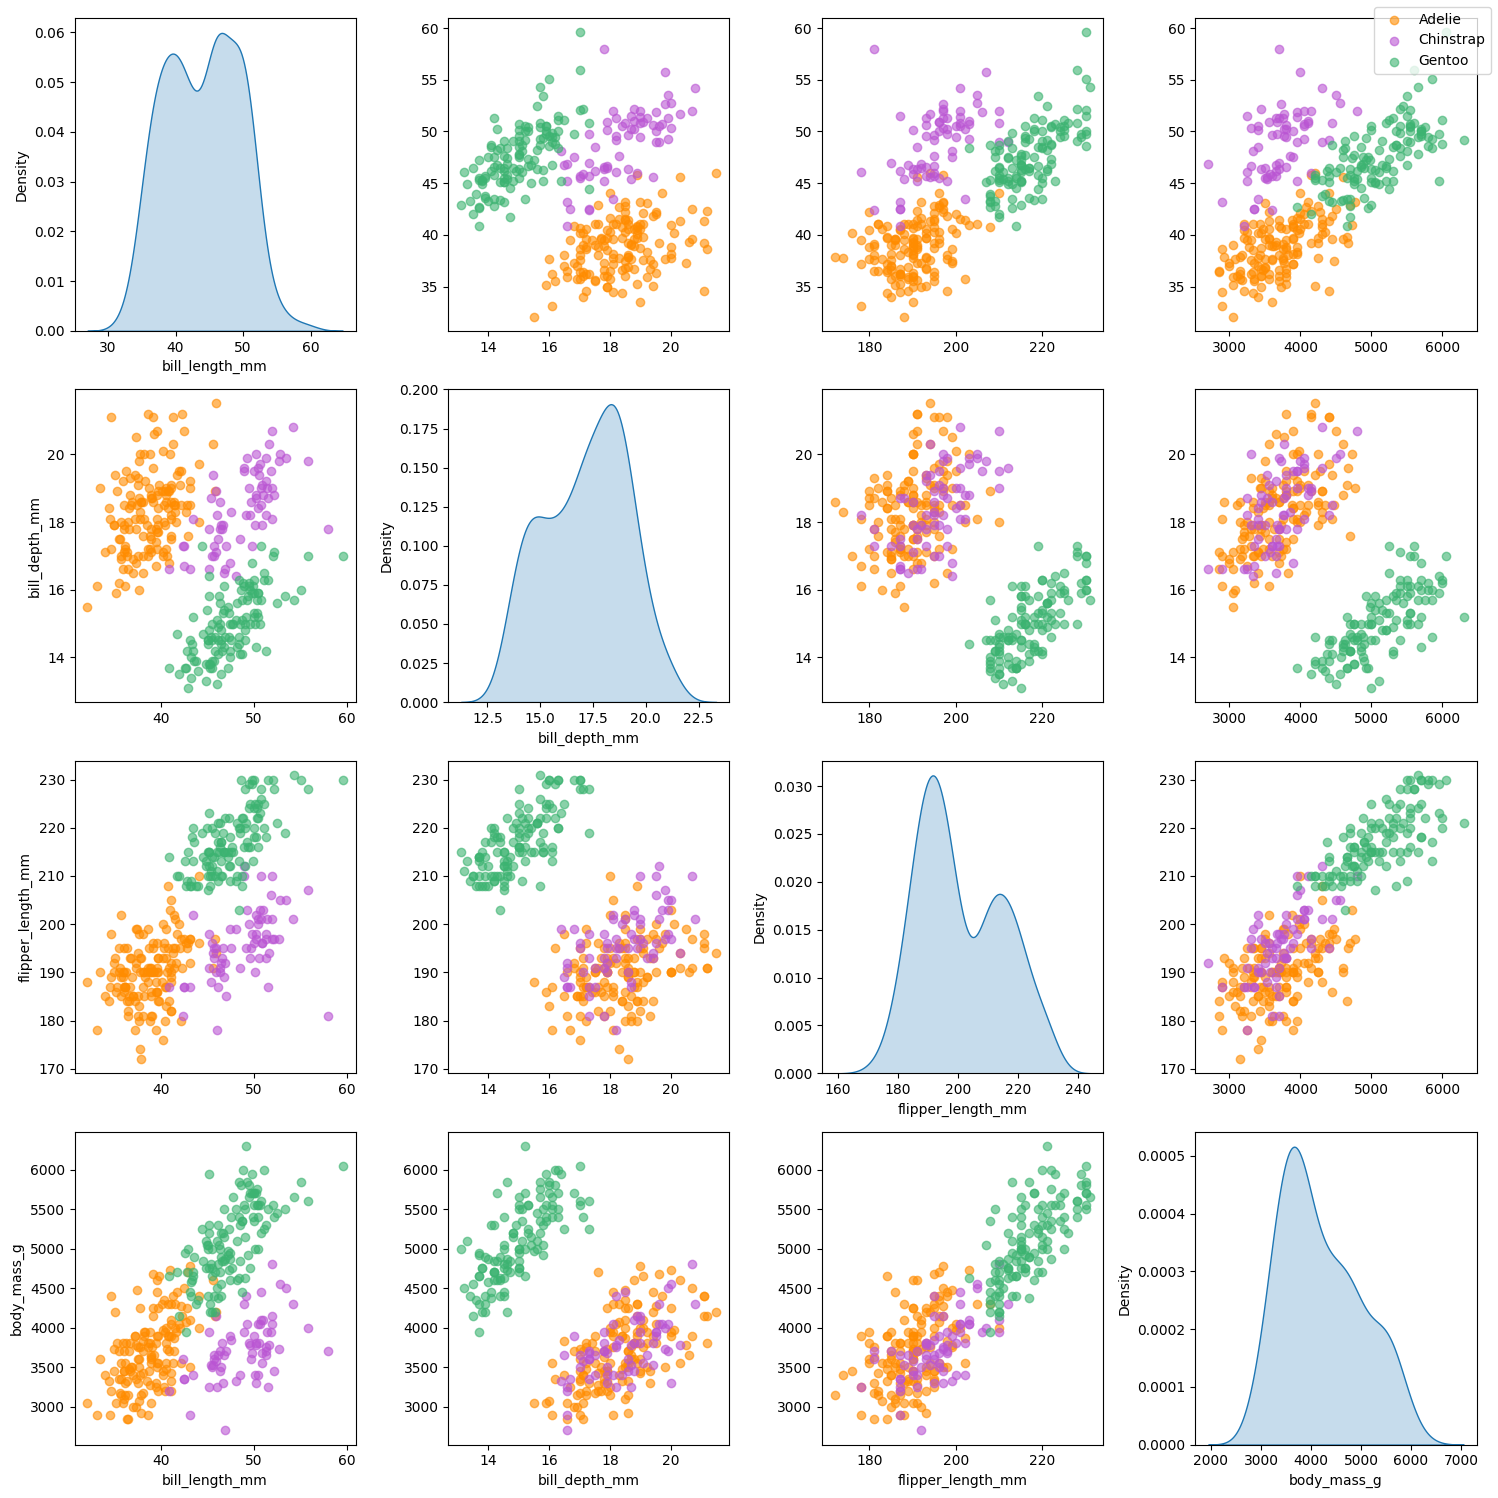

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns  

# Assuming 'df' is your DataFrame and 'custom_palette' is a dictionary mapping species to colors

feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Set up the figure and axes
fig, axs = plt.subplots(4, 4, figsize=(15, 15)) 

for i in range(4):
    for j in range(4):
        if i == j:
            # Plot density plot on the diagonal
            sns.kdeplot(data=df, x=feature_names[i], ax=axs[j, i], fill=True)
            axs[j, i].set_ylabel('Density')
        else:
            for species, color in custom_palette.items():
                # Filter points belonging to the current species
                points = df[df['species'] == species]
                # Scatter plot for points of the current species with the specified color
                axs[j, i].scatter(points[feature_names[i]], points[feature_names[j]], c=color, label=species, alpha=0.6)
            # Set the labels for the last column and first row
            if j == 3:
                axs[j, i].set_xlabel(feature_names[i])
            if i == 0:
                axs[j, i].set_ylabel(feature_names[j])

# Creating a single legend for the whole figure
handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


Plot elbow plot

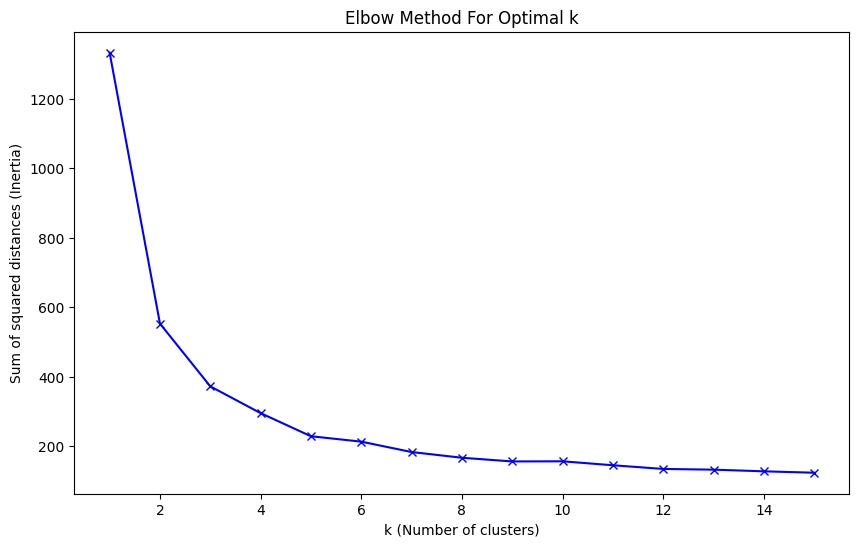

In [8]:
# Sum of squared distances for a range of number of clusters
inertias = []
K = 15 # 15 clusters
for k in range(1, K+1):
    kmm = KMeans(n_clusters=k)
    kmm.fit(features)
    inertias.append(kmm.inertia_)

# Plot elbow plot
plt.figure(figsize=(10,6))
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

Train on train dataset, then optimise on validation dataset

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, silhouette_score, f1_score, accuracy_score
from sklearn.cluster import KMeans
from scipy.stats import mode
import numpy as np

# Assuming df is your original DataFrame and already loaded

# Get a DataFrame of features and the labels
features_unscaled = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
labels = df['species']

# Initialise the StandardScaler and scale features
scaler = StandardScaler()
features = scaler.fit_transform(features_unscaled)

# Split the scaled data into training + validation, and test sets
features_train_val, features_test, labels_train_val, labels_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Further split the training set into a smaller training set and a validation set
features_train, features_val, labels_train, labels_val = train_test_split(
    features_train_val,
    labels_train_val,
    test_size=0.25, # This splits the original training data 60% training, 20% validation, 20% test
    random_state=42
)

# Initialize LabelEncoder
le = LabelEncoder()
labels_train_encoded = le.fit_transform(labels_train)
labels_val_encoded = le.transform(labels_val)
labels_test_encoded = le.transform(labels_test)

# Define your parameter grid
param_grid = {
    'n_clusters': range(2, 10),  # Number of clusters
    'init': ['k-means++', 'random'],  # Initialisation method for centroids
    'n_init': [5, 10, 20],  # The number of times KMeans is run with different centroid seeds
    'max_iter': [10, 20, 50]  # Max number of iterations the algorithm will run
}

# List of random states to consider for additional robustness in finding the best init
random_states = range(10)

# Placeholders for the best score and parameters based on validation set
best_avg_score = -1
best_params = None

def map_cluster_labels_to_true_labels(predicted_labels, true_labels):
    label_mapping = {}
    unique_labels = np.unique(predicted_labels)
    for label in unique_labels:
        # Find the most frequent true label in each predicted cluster
        mode_result = mode(true_labels[predicted_labels == label])
        mode_label = mode_result.mode  # Access the mode value directly
        label_mapping[label] = mode_label  # Access the mode value
    # Map each predicted label to the most frequent true label in its cluster
    mapped_labels = np.array([label_mapping[label] for label in predicted_labels])
    return mapped_labels

# Hyperparameter tuning
for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                accuracy_scores = []
                
                for random_state in random_states:
                    kmm = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, random_state=random_state)
                    kmm.fit(features_train)
                    
                    labels_predicted_val = kmm.predict(features_val)
                    mapped_labels_val = map_cluster_labels_to_true_labels(labels_predicted_val, labels_val_encoded)
                    
                    accuracy_scores.append(adjusted_rand_score(labels_val_encoded, mapped_labels_val))
                
                avg_acc = np.mean(accuracy_scores)
                
                if avg_acc > best_avg_score:
                    best_avg_score = avg_acc
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}



Best parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 5, 'max_iter': 10}
Test Set Accuracy: 0.9253731343283582


Return accuracy of model on test dataset

In [35]:
# Fit the model with the best parameters on the training + validation set
kmeans_best = KMeans(**best_params, random_state=42)
kmeans_best.fit(features_train_val)

# Predict on the test set and evaluate
labels_predicted_test = kmeans_best.predict(features_test)
mapped_labels_test = map_cluster_labels_to_true_labels(labels_predicted_test, labels_test_encoded)

# Calculate metrics for the test set
silhouette_test = silhouette_score(features_test, labels_predicted_test)
ari_test = adjusted_rand_score(labels_test_encoded, mapped_labels_test)
f1_test = f1_score(labels_test_encoded, mapped_labels_test, average='macro')
accuracy_test = accuracy_score(labels_test_encoded, mapped_labels_test)

# Output the best parameters and test set metrics
print(f"Best parameters: {best_params}")
print(f"Test Set Silhouette Score: {silhouette_test}")
print(f"Test Set ARI: {ari_test}")
print(f"Test Set F1 Score: {f1_test}")
print(f"Test Set Accuracy: {accuracy_test}")

Best parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 5, 'max_iter': 10}
Test Set Silhouette Score: 0.39307816063162637
Test Set ARI: 0.8077097188109486
Test Set F1 Score: 0.9109492005666869
Test Set Accuracy: 0.9253731343283582


Do a plot of cluster areas

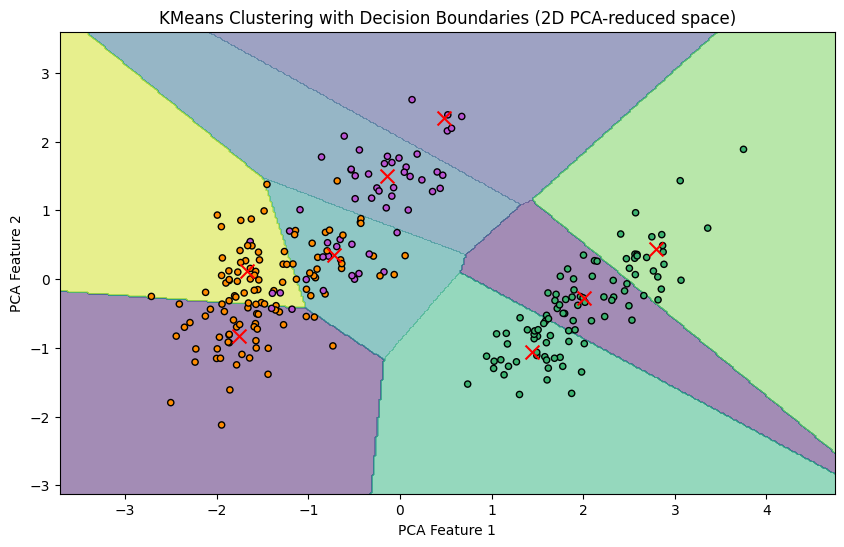

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Get a dataframe of features and labels
features_unscaled = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
labels = df['species']

# Initialise the StandardScaler and scale features
scaler = StandardScaler()
features = scaler.fit_transform(features_unscaled)

# Split the scaled data
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Reduce the dimensionality of the data to 2D for visualization
pca = PCA(n_components=2)
features_train_2d = pca.fit_transform(features_train)

# Fit KMeans on the 2D training data for visualization purposes
kmm_2d = KMeans(n_clusters=8, random_state=42)
kmm_2d.fit(features_train_2d)

# Create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = features_train_2d[:, 0].min() - 1, features_train_2d[:, 0].max() + 1
y_min, y_max = features_train_2d[:, 1].min() - 1, features_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the trained model.
Z = kmm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define the custom palette
custom_palette = {
    'Adelie': 'darkorange',
    'Chinstrap': 'mediumorchid',
    'Gentoo': 'mediumseagreen'
}

# Convert labels to colors based on our custom palette
colors = labels_train.map(custom_palette).values

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(features_train_2d[:, 0], features_train_2d[:, 1], c=colors, s=20, edgecolor='k')
plt.scatter(kmm_2d.cluster_centers_[:, 0], kmm_2d.cluster_centers_[:, 1], c='red', s=100, marker='x')

plt.title('KMeans Clustering with Decision Boundaries (2D PCA-reduced space)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()


Silhoutte scores for different clusters

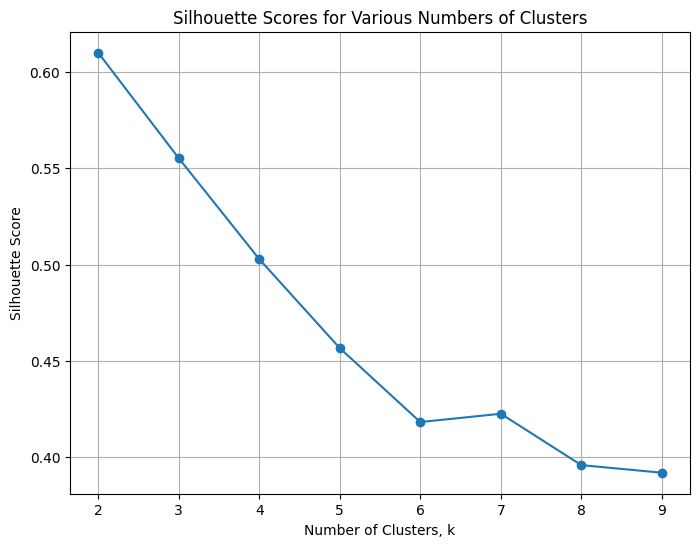

In [23]:
# Calculate silhouette scores for various values of k
k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_train_2d)
    score = silhouette_score(features_train_2d, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Code to show cluster areas

For n_clusters = 2, the average silhouette_score is : 0.61
For n_clusters = 3, the average silhouette_score is : 0.56
For n_clusters = 4, the average silhouette_score is : 0.50
For n_clusters = 5, the average silhouette_score is : 0.46


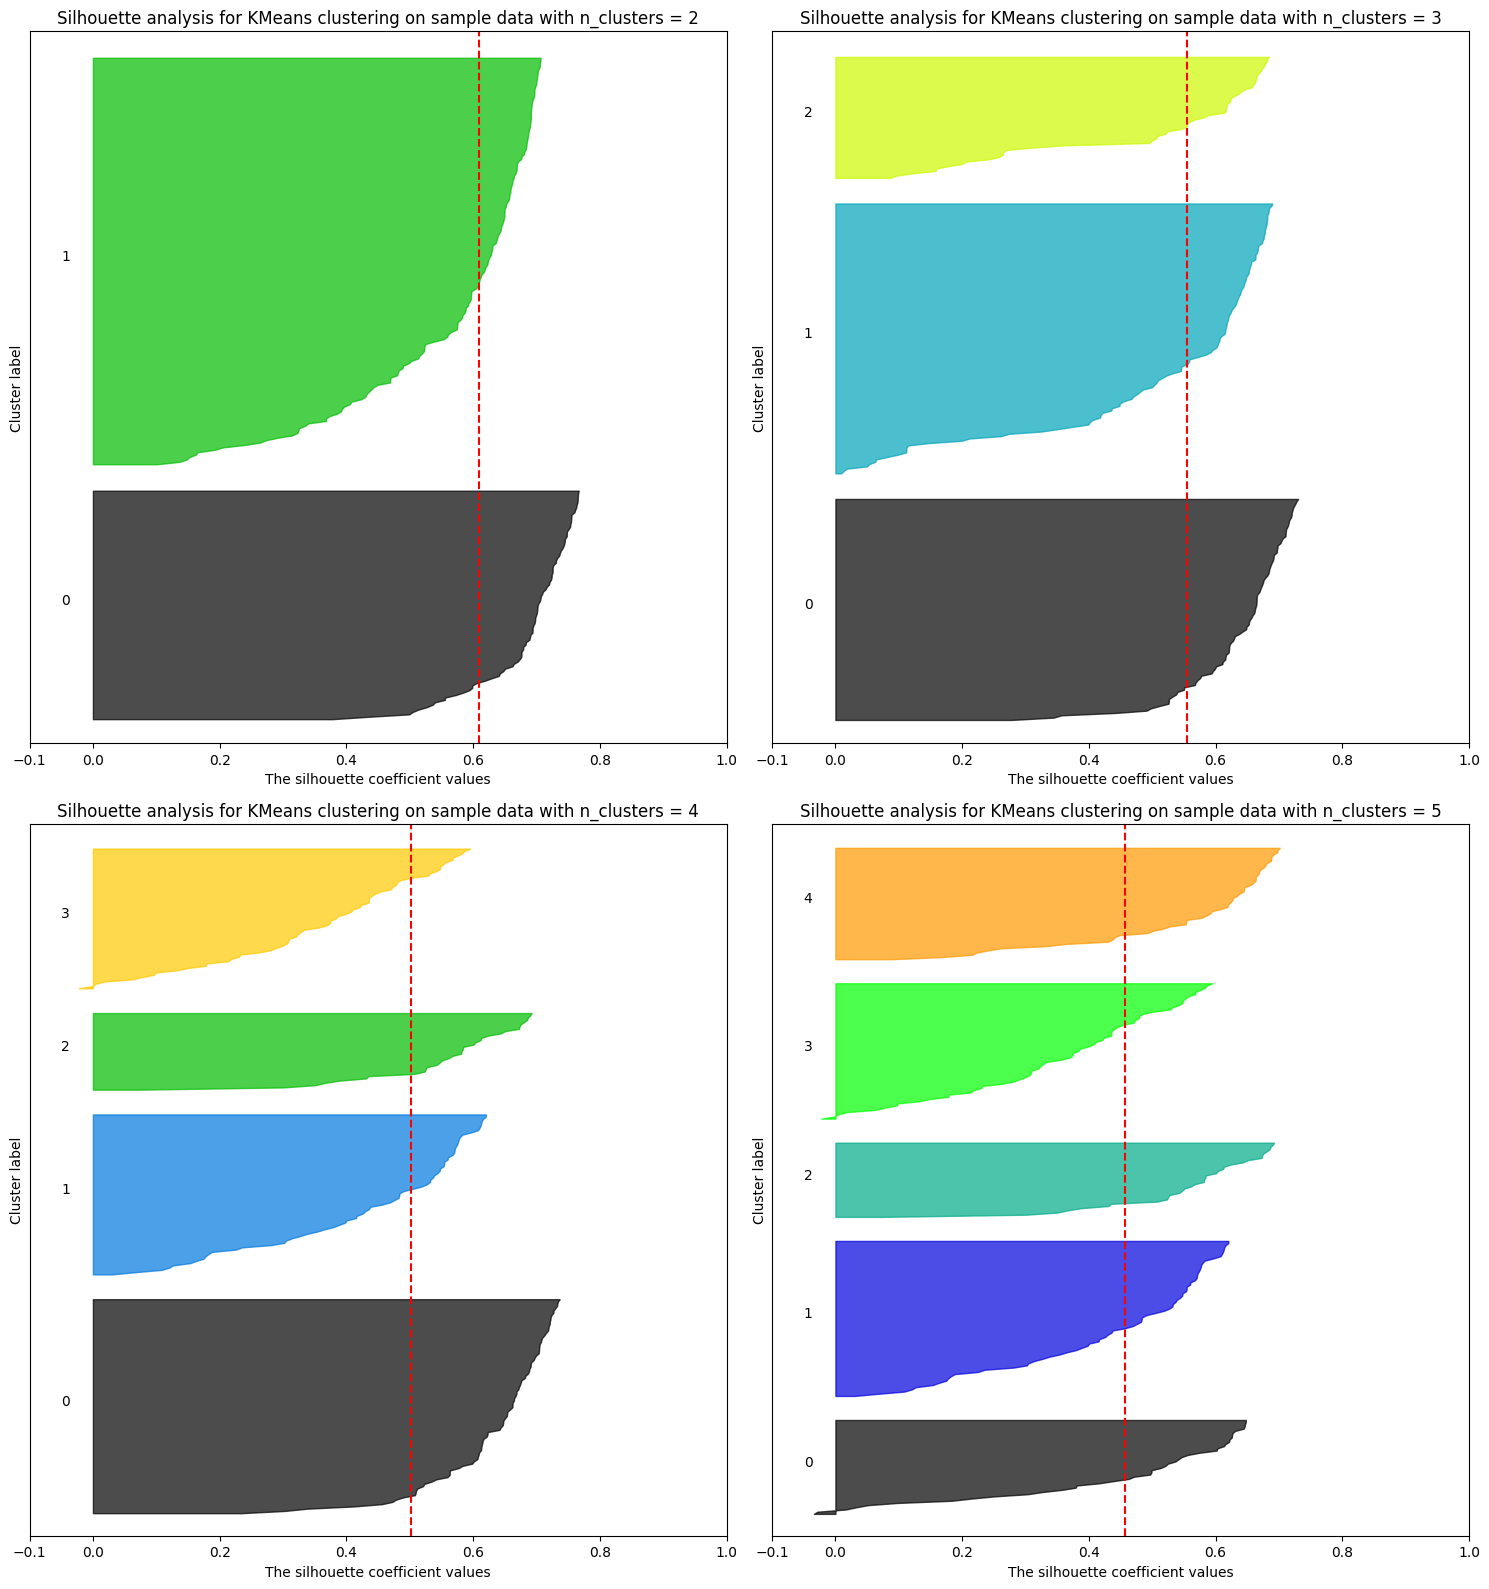

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Define a function to plot silhouette diagrams for a given k
def plot_silhouette_diagrams(X, range_n_clusters):
    n_rows = len(range_n_clusters) // 2 + len(range_n_clusters) % 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(15, 8 * n_rows))
    axs = axs.ravel()
    
    for i, n_clusters in enumerate(range_n_clusters):
        # Create a subplot with 1 row and 2 columns
        ax = axs[i]
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.2f}")
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        for j in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster j, and sort them
            jth_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == j]
        
            jth_cluster_silhouette_values.sort()
        
            size_cluster_j = jth_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
        
            color = cm.nipy_spectral(float(j) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                             0, jth_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
        
            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        
        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Hide empty subplots if any
    for i in range(len(range_n_clusters), n_rows * 2):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

# Plot silhouette diagrams for k=2,3,4,5 in a 2 by 2 layout
plot_silhouette_diagrams(features_train_2d, [2, 3, 4, 5])
